In [1]:
from PIL import Image
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def fit_normal_dist_per_class(orgiginal_image_filepath, train_image_filepath, other_pixels_color):
    image_per_label_pixels = set()
    orig_im = Image.open(orgiginal_image_filepath).convert('LA')
    orig_pixels = orig_im.load()
    width, height = orig_im.size
    i = 0
    j = 0
    while (i < width):
        while (j < height):
            pix = orig_pixels[i, j][0]
            if (pix != other_pixels_color):
                image_per_label_pixels.add((i, j))
            j += 1
        i += 1
        j = 0
    train_im = Image.open(train_image_filepath).convert('LA')
    train_pixels = train_im.load()
    data = [train_pixels[i, j][0] for (i, j) in image_per_label_pixels]
    mean, std = norm.fit(data)
    return mean, std, image_per_label_pixels

def fit_class_dists(class_original_image_filenames, noisy_train_image_filename, other_pixels_colors):
    class_means = list()
    class_stds = list()
    all_classes_image_per_label_pixels = list()
    for class_original_image_filename, other_pixels_color in zip(class_original_image_filenames, other_pixels_colors):
        class_mean, class_std, class_image_per_label_pixels = fit_normal_dist_per_class(
            base_path + class_original_image_filename, base_path + noisy_train_image_filename, other_pixels_color)
        class_means.append(class_mean)
        class_stds.append(class_std)
        all_classes_image_per_label_pixels.append(class_image_per_label_pixels)
    return all_classes_image_per_label_pixels, class_means, class_stds

In [3]:
def get_pistd_term(std):
    return float(np.math.sqrt(2 * np.math.pi * np.math.pow(std, 2)))

def get_exp_term(mean, std, val):
    return (float(np.math.pow(val - mean, 2)) / float(2 * np.math.pow(std, 2)))

def get_gaussian_naive_bayes_prob_per_class(mean, std, val):
    exp_term = get_exp_term(mean, std, val)
    pistd_term = get_pistd_term(std)
    return float(np.math.exp(-1 * exp_term)) / pistd_term

def segment_image(base_filepath,
                  test_image_filename, all_classes_image_per_label_pixels, class_means, class_stds):
    im = Image.open(base_filepath + test_image_filename).convert('LA')
    pixels = im.load()
    width, height = im.size
    # print(width, height)
    pixel_class_indexes = [[0 for x in range(height)] for y in range(width)]
    i = 0
    j = 0
    all_trues = 0
    all_pixels = 0
    while (i < width):
        while (j < height):
            all_pixels += 1
            pix = pixels[i, j][0]
            prob = -1
            is_true = False
            for idx, class_mean in enumerate(class_means):
                new_prob = get_gaussian_naive_bayes_prob_per_class(class_means[idx], class_stds[idx], pix)
                if new_prob > prob:
                    prob = new_prob
                    if (i, j) in all_classes_image_per_label_pixels[idx]:
                        is_true = True
                    else:
                        is_true = False
                        # print(i, j)
                    pixel_class_indexes[i][j] = idx

            if is_true:
                all_trues += 1
            j += 1
        i += 1
        j = 0
    return all_pixels, all_trues, pixel_class_indexes

In [4]:
def report_segment_image(base_filepath, base_filepath_output , test_image_filename, 
                         labeled_image_filenme, noisy_train_image_filename,
                         class_original_image_filenames, other_pixels_colors):
    
    all_classes_image_per_label_pixels, class_means, class_stds = fit_class_dists(class_original_image_filenames,
                                                                                  noisy_train_image_filename,
                                                                                  other_pixels_colors)
    all_pixels_count, all_trues_count, pixel_class_indexes = segment_image(base_path,
                                                                           test_image_filename,
                                                                           all_classes_image_per_label_pixels,
                                                                           class_means, class_stds)
    saving_im = Image.new('LA', (len(pixel_class_indexes), len(pixel_class_indexes[0])))
    width, height = saving_im.size
    i = 0
    j = 0
    im = Image.open(base_filepath + test_image_filename).convert('LA')
    pixels = im.load()
    while (i < width):
        while (j < height):
            saving_im.putpixel((i, j), (int(class_means[pixel_class_indexes[i][j]]), pixels[i, j][1]))
            j += 1
        i += 1
        j = 0

    saving_im.save(base_filepath_output + labeled_image_filenme, 'png')
    return float(all_trues_count) / float(all_pixels_count), saving_im, class_means, class_stds

In [5]:
base_path = "input/"
base_path_output = "output/"
class_original_image_filenames = ["test1-c1.png", "test1-c2.png", "test1-c3.png"]
other_pixels_colors = [0, 0, 255]
noisy_train_image_filename = "test1noisy0-01.bmp"

noises = ["01","05", "09", "3"]
accs = []
imgs = []
for noise in noises:
    acc, img, class_means, class_stds = report_segment_image(base_path, base_path_output, "test1noisy0-" + noise + ".bmp", "test1-labeled-" + noise + "-nb.png", noisy_train_image_filename,
                         class_original_image_filenames, other_pixels_colors)
    accs.append(acc)
    imgs.append(img)
    
print("Class Means", class_means)
print("Class Stds", class_stds)

Class Means [234.61367726454708, 124.006006006006, 20.75567067343962]
Class Stds [19.105007841665362, 22.24281697247079, 21.196421605936784]


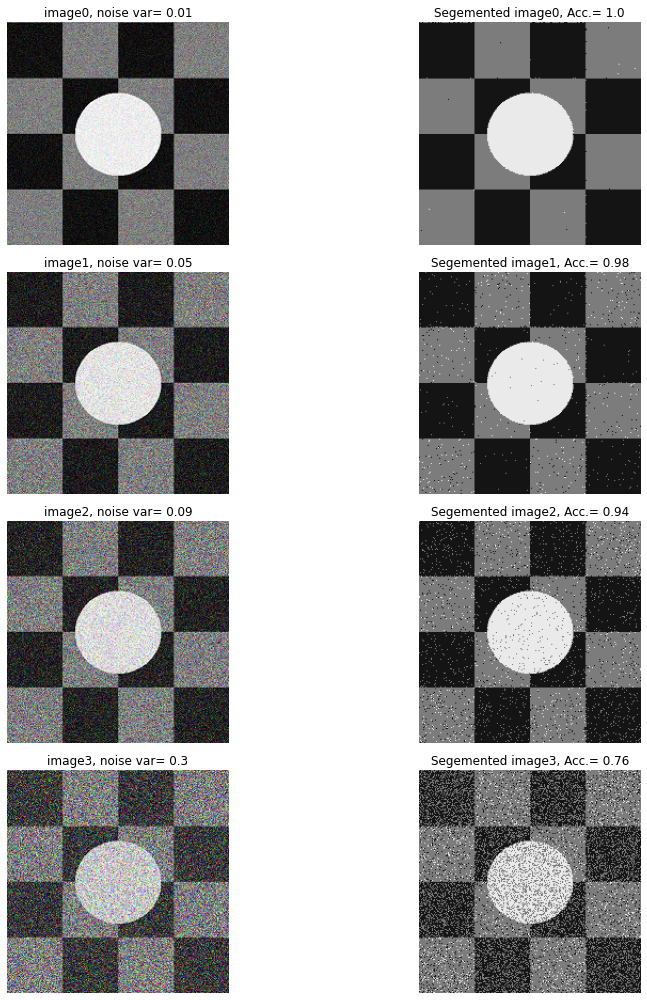

In [6]:
fig, axs = plt.subplots(4,2, figsize=(14,14))

for i in range(4):
    axs[i][0].imshow(mpimg.imread("input/test1noisy0-" + noises[i] + ".bmp"))
    axs[i][0].axis("off")
    axs[i][0].title.set_text('image'+str(i)+', noise var= 0.'+str(noises[i]))
    
    axs[i][1].imshow(imgs[i])
    axs[i][1].axis("off")
    axs[i][1].title.set_text('Segemented image'+str(i)+ ', Acc.= '+str(round(accs[i],2)))

plt.tight_layout()
plt.show()